In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import glob
import os.path


import openpyxl
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import string

import pandas as pd
import yfinance as yf
import time
import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
folder=r"C:\Users\cwesterb\Stock Data 2-10-2022\QTR"
file=r"\complete_data_trimmed.csv"
companyDF=pd.read_csv(folder+file)
companyDF.head()

,Ticker,Fiscal Year,Fiscal Period,Report Date,Shares (Diluted),Revenue,Gross Profit,Operating Income (Loss),Pretax Income (Loss),Net Income (Common),...,PB (Tangible),Faustmann Ratio,ROIC,Profit Margin,Interest pct of Income,Income pct of Revenue,Earnings per Share,Debt pct of Cash,ROA,ROE
0,A,2010,Q3,7/31/2010,352000000,1.384000e+09,725000000,115000000,227000000,205000000,...,5.435014,1.630620,0.149736,0.523844,0.092511,0.164017,0.644886,0.647820,0.099780,0.291815
1,A,2010,Q4,10/31/2010,356000000,1.576000e+09,834000000,203000000,243000000,292000000,...,5.409706,1.653095,0.141547,0.529188,0.065844,0.154188,0.682584,0.566629,0.100248,0.360939
2,A,2011,Q1,1/31/2011,355000000,1.519000e+09,816000000,211000000,198000000,193000000,...,5.488451,1.776255,0.148204,0.537196,0.095960,0.130349,0.557746,0.000379,0.098458,0.231207
3,A,2011,Q2,4/30/2011,355000000,1.677000e+09,900000000,266000000,260000000,200000000,...,4.923427,1.722269,0.171986,0.536673,0.065385,0.155039,0.732394,0.000000,0.120245,0.201969
4,A,2011,Q3,7/31/2011,357000000,1.691000e+09,892000000,281000000,281000000,330000000,...,2.780005,1.015562,0.180157,0.527499,0.060498,0.166174,0.787115,0.000000,0.128413,0.314286


In [3]:
SP500=yf.Ticker("SPY").history(start="1999-06-30",interval='1d')
SP500=pd.DataFrame(SP500['Close'])
print(SP500)

                 Close
Date                  
1999-06-30   90.475945
1999-07-01   91.156975
1999-07-02   92.065056
1999-07-06   92.044449
1999-07-07   92.168236
...                ...
2022-05-31  412.929993
2022-06-01  409.589996
2022-06-02  417.390015
2022-06-03  410.540009
2022-06-06  416.186005

[5772 rows x 1 columns]


In [4]:
#Date Check
def date2qtr(x):
    QTR=(x.month-1)//3+1
    QTR="Q"+str(QTR)
    return QTR

def date2year(x):
    return x.year

def strdate2qtr(x):
    return date2qtr(datetime.strptime(x,"%m/%d/%Y"))

def strdate2year(x):
    return date2year(datetime.strptime(x,"%m/%d/%Y"))

In [5]:
def TTM_sum(qtr_array):
    qtr_array_1=np.roll(qtr_array,1)
    qtr_array_1[0] = 0
    qtr_array_2=np.roll(qtr_array_1,1)
    qtr_array_2[0] = 0
    qtr_array_3=np.roll(qtr_array_2,1)
    qtr_array_3[0] = 0
    TTM_array=qtr_array+qtr_array_1+qtr_array_2+qtr_array_3
    return TTM_array

def HIST_ave(qtr_array):
    hist_array=[]
    total=0
    for i in range(len(qtr_array)):
        total=total+qtr_array[i]
        hist_array.append(total/(i+1))
    return hist_array

In [6]:
ticker_list=companyDF.Ticker.values
ticker_list = list(dict.fromkeys(ticker_list))
#print(ticker_list)
newDF=pd.DataFrame()
for ticker in ticker_list:
    
    tempDF=companyDF[companyDF.Ticker==ticker]
    Gross_profit_TTM=TTM_sum(tempDF['Gross Profit'].values)
    if(len(Gross_profit_TTM)>12):
        Revenue_TTM=TTM_sum(tempDF['Revenue'].values)
        GM_TTM=Gross_profit_TTM/Revenue_TTM
        tempDF['Gross Margin TTM']=GM_TTM
        income_TTM=TTM_sum(tempDF['Pretax Income (Loss)'].values)
        PM_TTM=income_TTM/Revenue_TTM
        tempDF['Profit Margin TTM']=PM_TTM
        dividend_TTM=TTM_sum(tempDF['Dividends Paid'].values)
        stock_price=tempDF['Stock Price'].values
        div_pct=-dividend_TTM/tempDF["Market Cap"].values
        tempDF['Dividend PCT']=div_pct


        FCF_TTM=TTM_sum(tempDF['Free Cash Flow'].values)

        PE_TTM=tempDF["Market Cap"].values/income_TTM
        if(len(PE_TTM)>3):
            PE_TTM[0]=PE_TTM[0]/4
            PE_TTM[1]=PE_TTM[1]/2
            PE_TTM[2]=PE_TTM[2]*3/4

        tempDF['PE TTM']=PE_TTM
        PE_hist=HIST_ave(PE_TTM)
        tempDF['PE Hist']=PE_hist

        PB=tempDF['PB'].values

        PB_hist=HIST_ave(PB)
        tempDF['PB Hist']=PB_hist
        PB_tang=tempDF['PB (Tangible)'].values
        PB_tang_hist=HIST_ave(PB_tang)
        tempDF['PB (tangible) Hist']=PB_tang_hist
        Fasutmann=tempDF['Faustmann Ratio'].values
        Faustmann_hist=HIST_ave(Fasutmann)
        tempDF['Faustmann Hist']=Faustmann_hist
        invested_capital=tempDF['Invested Capital'].values
        ROIC_TTM=income_TTM/invested_capital

        ROA_TTM=income_TTM/tempDF['Total Assets'].values

        ROE_TTM=income_TTM/tempDF['Total Equity'].values
        if(len(ROE_TTM)>3):
            ROE_TTM[0]=ROE_TTM[0]/4
            ROE_TTM[1]=ROE_TTM[1]/2
            ROE_TTM[2]=ROE_TTM[2]*3/4
            ROA_TTM[0]=ROA_TTM[0]/4
            ROA_TTM[1]=ROA_TTM[1]/2
            ROA_TTM[2]=ROA_TTM[2]*3/4
            ROIC_TTM[0]=ROIC_TTM[0]/4
            ROIC_TTM[1]=ROIC_TTM[1]/2
            ROIC_TTM[2]=ROIC_TTM[2]*3/4

        tempDF['ROE TTM']=ROE_TTM
        tempDF['ROA TTM']=ROA_TTM
        tempDF['ROIC TTM']=ROIC_TTM
        if(len(stock_price)>4):
            future_stock_price=np.roll(stock_price,-4)
        else:
            future_stock_price=stock_price
        tempDF['Future Stock Price (1Y)']=future_stock_price

        newDF = pd.concat([newDF,tempDF])
    #mlDF.append(tempDF, ignore_index=True)
    #mlDF=pd.concat([mlDF, tempDF], ignore_index=True)

C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on 

In [12]:
start_year=min(newDF["Fiscal Year"].values)
end_year=max(newDF["Fiscal Year"].values)
qtr_list=["Q1", "Q2", "Q3", "Q4"]
magicDF=pd.DataFrame()
for year in range(start_year, end_year+1):
    for qtr in qtr_list:
        print(year,", ",qtr)
        tempDF=newDF[(newDF["Fiscal Year"]==year) & (newDF["Fiscal Period"]==qtr)]
        tempDF.sort_values(inplace=True, by='ROIC TTM', ascending=False)
        length=len(tempDF['Ticker'].values)
        if(length>0):
            rank=range(1,length+1)
            tempDF["ROIC Rank"]=rank
            tempDF.sort_values(inplace=True, by='PE TTM', ascending=False)
            tempDF["PE Rank"]=rank
            tempDF["Magic Score"]=tempDF["PE Rank"].values+tempDF["ROIC Rank"]
            max_magic=max(tempDF["Magic Score"].values)
            tempDF["Magic Ratio"]=1-(tempDF["Magic Score"].values/max_magic)
            magicDF = pd.concat([magicDF,tempDF])

magicDF=magicDF[["Ticker","Fiscal Year","Fiscal Period","Report Date",'Shares (Diluted)','Revenue','Net Income (Common)','Invested Capital','Earnings per Share','Gross Margin TTM', 'Profit Margin TTM',"PE TTM","PE Rank","ROIC TTM","ROIC Rank","Magic Score","Magic Ratio",]]
        
            


1999 ,  Q1
1999 ,  Q2
1999 ,  Q3
1999 ,  Q4
2000 ,  Q1
2000 ,  Q2
2000 ,  Q3
2000 ,  Q4
2001 ,  Q1
2001 ,  Q2
2001 ,  Q3
2001 ,  Q4
2002 ,  Q1
2002 ,  Q2
2002 ,  Q3
2002 ,  Q4
2003 ,  Q1


C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2003 ,  Q2
2003 ,  Q3
2003 ,  Q4
2004 ,  Q1
2004 ,  Q2
2004 ,  Q3
2004 ,  Q4
2005 ,  Q1
2005 ,  Q2
2005 ,  Q3
2005 ,  Q4
2006 ,  Q1
2006 ,  Q2
2006 ,  Q3
2006 ,  Q4
2007 ,  Q1
2007 ,  Q2
2007 ,  Q3
2007 ,  Q4
2008 ,  Q1
2008 ,  Q2
2008 ,  Q3
2008 ,  Q4
2009 ,  Q1
2009 ,  Q2
2009 ,  Q3
2009 ,  Q4
2010 ,  Q1
2010 ,  Q2
2010 ,  Q3
2010 ,  Q4


C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2011 ,  Q1
2011 ,  Q2
2011 ,  Q3
2011 ,  Q4
2012 ,  Q1
2012 ,  Q2
2012 ,  Q3
2012 ,  Q4
2013 ,  Q1
2013 ,  Q2


C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2013 ,  Q3
2013 ,  Q4
2014 ,  Q1
2014 ,  Q2
2014 ,  Q3
2014 ,  Q4
2015 ,  Q1


C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2015 ,  Q2
2015 ,  Q3
2015 ,  Q4
2016 ,  Q1
2016

C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

 ,  Q2
2016 ,  Q3
2016 ,  Q4
2017 ,  Q1
2017

C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

 ,  Q2
2017 ,  Q3
2017 ,  Q4
2018 ,  Q1


C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2018 ,  Q2
2018 ,  Q3
2018 ,  Q4
2019 ,  Q1


C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

2019 ,  Q2
2019 ,  Q3
2019 ,  Q4


C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2020 ,  Q1
2020 ,  Q2
2020 ,  Q3
2020 ,  Q4


C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021 ,  Q1
2021 ,  Q2
2021 ,  Q3


C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021 ,  Q4
2022 ,  Q1
2022 ,  Q2
2022 ,  Q3
2022 ,  Q4


C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\cwesterb\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [11]:
print(newDF.columns)

Index(['Ticker', 'Fiscal Year', 'Fiscal Period', 'Report Date',
       'Shares (Diluted)', 'Revenue', 'Gross Profit',
       'Operating Income (Loss)', 'Pretax Income (Loss)',
       'Net Income (Common)',
       'Cash, Cash Equivalents & Short Term Investments',
       'Total Current Assets', 'Property, Plant & Equipment, Net',
       'Intangible Assets', 'Goodwill', 'Other Intangible Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Short Term Debt',
       'Total Current Liabilities', 'Long Term Debt',
       'Total Noncurrent Liabilities', 'Total Liabilities', 'Treasury Stock',
       'Retained Earnings', 'Total Equity', 'Depreciation & Amortization',
       'Net Cash from Operating Activities', 'Dividends Paid', 'Stock Price',
       'Stock pct Increase', 'Op. Invested Capital', 'Fin. Invested Capital',
       'Invested Capital', 'Owner Earnings', 'Free Cash Flow', 'Net Worth',
       'Market Cap', 'PE', 'PB', 'PB (Tangible)', 'Faustmann Ratio', 'ROIC',
       'Profit Ma

In [13]:
magicDF.head(n=55)

,Ticker,Fiscal Year,Fiscal Period,Report Date,Shares (Diluted),Revenue,Net Income (Common),Invested Capital,Earnings per Share,Gross Margin TTM,Profit Margin TTM,PE TTM,PE Rank,ROIC TTM,ROIC Rank,Magic Score,Magic Ratio
45337,NWPX,1999,Q2,6/30/1999,9235000,6.101100e+07,3095000,1.913360e+08,0.563184,0.193375,0.085247,7.546385,1,0.006796,1,2,0.000000
45338,NWPX,1999,Q3,9/30/1999,9235000,6.332200e+07,3864000,2.168910e+08,0.703628,0.201652,0.094094,4.785639,1,0.026970,1,2,0.000000
45339,NWPX,1999,Q4,12/31/1999,9235000,5.844300e+07,3683000,2.111280e+08,0.639740,0.207303,0.096331,5.212291,1,0.062546,1,2,0.000000
45340,NWPX,2000,Q1,3/31/2000,9235000,6.399100e+07,2361000,2.259060e+08,0.426096,0.200019,0.087297,5.841002,1,0.095358,1,2,0.000000
45341,NWPX,2000,Q2,6/30/2000,9235000,6.949000e+07,3065000,2.433590e+08,0.553113,0.197363,0.084033,5.435772,1,0.088137,1,2,0.000000
244,AAPL,2000,Q3,6/30/2000,24900176000,1.825000e+09,200000000,3.855000e+09,0.010843,0.297534,0.147945,5.816849,1,0.017510,2,3,0.000000
45342,NWPX,2000,Q3,9/30/2000,9235000,7.598600e+07,2641000,2.377430e+08,0.476665,0.185170,0.072237,4.473628,2,0.081403,1,3,0.000000
35934,LECO,2000,Q4,12/31/2000,86108000,2.513610e+08,8661000,5.385580e+08,0.143471,0.341576,0.049148,11.800150,1,0.005735,3,4,0.555556
245,AAPL,2000,Q4,9/30/2000,24900176000,1.870000e+09,170000000,4.054000e+09,0.009197,0.273342,0.135047,6.962412,2,0.061544,2,4,0.555556
45343,NWPX,2000,Q4,12/31/2000,9235000,7.194200e+07,2624000,2.304860e+08,0.456524,0.174895,0.062759,6.144117,3,0.076625,1,4,0.555556


In [14]:
magicDF.to_csv(r'C:\Users\cwesterb\Stocks\Magic Formula\magic_formula_fundamentals.csv',index=False )

In [8]:
magicDF=magicDF[["Ticker","Fiscal Year","Fiscal Period","Report Date","PE Rank","ROIC Rank","Magic Score","Magic Ratio"]]
magicDF.head(n=55)

,Ticker,Fiscal Year,Fiscal Period,Report Date,PE Rank,ROIC Rank,Magic Score,Magic Ratio
45337,NWPX,1999,Q2,6/30/1999,1,1,2,0.000000
45338,NWPX,1999,Q3,9/30/1999,1,1,2,0.000000
45339,NWPX,1999,Q4,12/31/1999,1,1,2,0.000000
45340,NWPX,2000,Q1,3/31/2000,1,1,2,0.000000
45341,NWPX,2000,Q2,6/30/2000,1,1,2,0.000000
244,AAPL,2000,Q3,6/30/2000,1,2,3,0.000000
45342,NWPX,2000,Q3,9/30/2000,2,1,3,0.000000
35934,LECO,2000,Q4,12/31/2000,1,3,4,0.555556
245,AAPL,2000,Q4,9/30/2000,2,2,4,0.555556
45343,NWPX,2000,Q4,12/31/2000,3,1,4,0.555556


In [9]:
newDF=newDF.merge(magicDF, left_on=["Ticker","Fiscal Year","Fiscal Period","Report Date"], right_on=["Ticker","Fiscal Year","Fiscal Period","Report Date"])
newDF.head(n=55)

,Ticker,Fiscal Year,Fiscal Period,Report Date,Shares (Diluted),Revenue,Gross Profit,Operating Income (Loss),Pretax Income (Loss),Net Income (Common),...,PB (tangible) Hist,Faustmann Hist,ROE TTM,ROA TTM,ROIC TTM,Future Stock Price (1Y),PE Rank,ROIC Rank,Magic Score,Magic Ratio
0,A,2010,Q3,7/31/2010,352000000,1.384000e+09,725000000,115000000,227000000,205000000,...,5.435014,1.630620,0.020196,0.006236,0.009359,20.402281,327,493,820,0.292494
1,A,2010,Q4,10/31/2010,356000000,1.576000e+09,834000000,203000000,243000000,292000000,...,5.422360,1.641857,0.072621,0.024237,0.034222,22.804865,332,465,797,0.388335
2,A,2011,Q1,1/31/2011,355000000,1.519000e+09,816000000,211000000,198000000,193000000,...,5.444390,1.686657,0.150045,0.062282,0.093750,29.059385,300,359,659,0.521423
3,A,2011,Q2,4/30/2011,355000000,1.677000e+09,900000000,266000000,260000000,200000000,...,5.314150,1.695560,0.234284,0.107296,0.153465,25.676498,252,273,525,0.724409
4,A,2011,Q3,7/31/2011,357000000,1.691000e+09,892000000,281000000,281000000,330000000,...,4.807321,1.559560,0.233810,0.112190,0.157397,25.226440,577,302,879,0.562033
5,A,2011,Q4,10/31/2011,353000000,1.728000e+09,921000000,313000000,293000000,289000000,...,4.494164,1.472420,0.239110,0.113945,0.160673,26.929897,642,338,980,0.551487
6,A,2012,Q1,1/31/2012,352000000,1.635000e+09,874000000,271000000,256000000,230000000,...,4.355854,1.441459,0.242276,0.119793,0.163541,27.675091,496,344,840,0.617660
7,A,2012,Q2,4/30/2012,354000000,1.733000e+09,918000000,300000000,293000000,255000000,...,4.174603,1.394883,0.237672,0.119303,0.165512,28.276648,618,372,990,0.561947
8,A,2012,Q3,7/31/2012,353000000,1.723000e+09,890000000,270000000,238000000,243000000,...,4.225286,1.455507,0.221629,0.110690,0.221311,33.985649,640,225,865,0.618270
9,A,2012,Q4,10/31/2012,353000000,1.767000e+09,922000000,278000000,256000000,425000000,...,4.242861,1.437147,0.201157,0.098994,0.139345,38.012222,647,464,1111,0.519048


In [34]:
newDF.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
newDF['Fiscal Year']=newDF['Report Date'].apply(strdate2year)
newDF['Fiscal Period']=newDF['Report Date'].apply(strdate2qtr)

In [91]:
years=[2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
#years=[2008]
transaction_columns=['Date',"Action","Symbol","Quantity","Price"]
transactionsDF=pd.DataFrame()
starting_money=10000
company_num=10
sells=[]
buys=[]
for i in range(company_num):
    buys.append("Buy")
    sells.append("Sell")


#qtrs=["Q1","Q2","Q3","Q4"]
qtrs=["Q4"]
transactionsDF=pd.DataFrame()
portfolio=[]
portfolio.append(starting_money)


for year in years:
    for qtr in qtrs:
        #filter to the current year
        tempDF=newDF[newDF["Fiscal Year"]==year]
        #filter to the current qtr
        tempDF=tempDF[tempDF["Fiscal Period"]==qtr]
        #filter by magic score
        tempDF=tempDF.sort_values(by=['Magic Score'])
        #grab the top 10
        tempDF=tempDF.head(n=10)
        temp_transactionsDF=pd.DataFrame()
        temp_transactionsDF['Date']=tempDF["Report Date"].values
        temp_transactionsDF['Action']=buys
        temp_transactionsDF['Symbol']=tempDF["Ticker"].values
        temp_transactionsDF['Quantity']=(starting_money/company_num)/tempDF["Stock Price"].values
        temp_transactionsDF['Price']=tempDF["Stock Price"].values
        transactionsDF=pd.concat([transactionsDF, temp_transactionsDF],ignore_index=True)
        temp_dates=temp_transactionsDF['Date'].values
        new_dates=[]
        for item in temp_dates:
            temp=datetime.strptime(item,"%m/%d/%Y")
            temp=temp + relativedelta(years=1)
            temp = datetime.strftime(temp, "%m/%d/%Y").replace(' 0', '')
            new_dates.append(temp)
        temp_transactionsDF['Date']=new_dates
        temp_transactionsDF['Action']=sells
        temp_transactionsDF['Price']=tempDF["Future Stock Price (1Y)"].values
        transactionsDF=pd.concat([transactionsDF, temp_transactionsDF],ignore_index=True)
        starting_money=np.sum(temp_transactionsDF['Price'].values*temp_transactionsDF['Quantity'].values)
        portfolio.append(starting_money)
        #print(tempDF)
transactionsDF.head(n=20)

,Date,Action,Symbol,Quantity,Price
0,12/31/2008,Buy,AMZN,15.434480,64.790001
1,12/31/2008,Buy,STRA,7.296279,137.056168
2,12/31/2008,Buy,CVLT,97.560976,10.250000
3,12/31/2008,Buy,QDEL,90.579710,11.040000
4,10/31/2008,Buy,EXPO,133.883426,7.469184
5,12/31/2008,Buy,AAPL,240.776113,4.153236
6,12/31/2008,Buy,HAE,34.971150,28.594999
7,12/31/2008,Buy,CHH,65.116879,15.357001
8,12/31/2008,Buy,PRDO,40.535063,24.670000
9,12/31/2008,Buy,ICUI,31.715826,31.530001


In [50]:
transactionsDF.to_csv(r'C:\Users\cwesterb\Stocks\Magic Formula\stock_trades.csv',index=False )

In [69]:
SPY = yf.download(tickers = "SPY", start="2008-1-29", interval='3mo', threads= False)
initial=SPY['Adj Close'].values
SPY=SPY['Adj Close']

initial=initial[0]
SPY=SPY.dropna()

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>


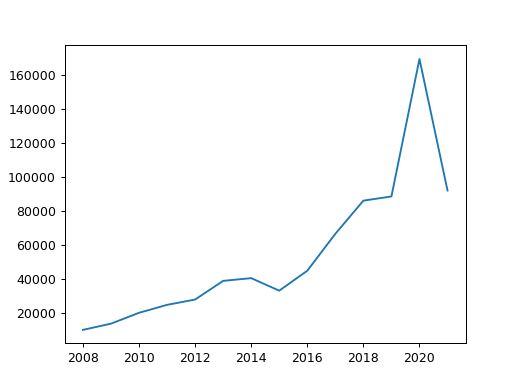

[10000, 13655.55068101382, 20042.137670414668, 24717.54836319617, 27841.132429018744, 38815.94741884779, 40423.64923317828, 33064.95226407243, 44766.78706958025, 66478.79437837808, 85978.79959396739, 88445.39750478802, 169262.24997701586, 91932.40695329537]


In [92]:
plt.figure()

plt.plot(years,portfolio[0:14])
#plt.plot(SPY/initial*10000)
print(portfolio[0:14])

In [85]:
SPY=pd.DataFrame(SPY)
SPY["Date"]=SPY.index
SPY["QTR"]=SPY["Date"].apply(date2qtr)
SPY["YEAR"]=SPY["Date"].apply(date2year)
SPY.to_csv(r"C:\Users\cwesterb\Stocks\Magic Formula\SPY.csv")

In [83]:
print(SPY.columns)

Index(['Adj Close'], dtype='object')


In [16]:
print(tempDF.columns)

Index(['Ticker', 'Fiscal Year', 'Fiscal Period', 'Report Date',
       'Shares (Diluted)', 'Revenue', 'Gross Profit',
       'Operating Income (Loss)', 'Pretax Income (Loss)',
       'Net Income (Common)',
       'Cash, Cash Equivalents & Short Term Investments',
       'Total Current Assets', 'Property, Plant & Equipment, Net',
       'Intangible Assets', 'Goodwill', 'Other Intangible Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Short Term Debt',
       'Total Current Liabilities', 'Long Term Debt',
       'Total Noncurrent Liabilities', 'Total Liabilities', 'Treasury Stock',
       'Retained Earnings', 'Total Equity', 'Depreciation & Amortization',
       'Net Cash from Operating Activities', 'Dividends Paid', 'Stock Price',
       'Stock pct Increase', 'Op. Invested Capital', 'Fin. Invested Capital',
       'Invested Capital', 'Owner Earnings', 'Free Cash Flow', 'Net Worth',
       'Market Cap', 'PE', 'PB', 'PB (Tangible)', 'Faustmann Ratio', 'ROIC',
       'Profit Ma

In [28]:
test=transactionsDF.Date.values
print(date2qtr(datetime.strptime(test[1],"%m/%d/%Y")))

Q4


In [32]:
testTemp=newDF
testTemp['Fiscal Year']=testTemp['Report Date'].apply(strdate2year)
testTemp['Fiscal Period']=testTemp['Report Date'].apply(strdate2qtr)
testTemp.head(n=55)

,Ticker,Fiscal Year,Fiscal Period,Report Date,Shares (Diluted),Revenue,Gross Profit,Operating Income (Loss),Pretax Income (Loss),Net Income (Common),...,PB (tangible) Hist,Faustmann Hist,ROE TTM,ROA TTM,ROIC TTM,Future Stock Price (1Y),PE Rank,ROIC Rank,Magic Score,Magic Ratio
0,A,2010,Q3,7/31/2010,352000000,1.384000e+09,725000000,115000000,227000000,205000000,...,5.435014,1.630620,0.020196,0.006236,0.009359,20.402281,327,493,820,0.292494
1,A,2010,Q4,10/31/2010,356000000,1.576000e+09,834000000,203000000,243000000,292000000,...,5.422360,1.641857,0.072621,0.024237,0.034222,22.804865,332,465,797,0.388335
2,A,2011,Q1,1/31/2011,355000000,1.519000e+09,816000000,211000000,198000000,193000000,...,5.444390,1.686657,0.150045,0.062282,0.093750,29.059385,300,359,659,0.521423
3,A,2011,Q2,4/30/2011,355000000,1.677000e+09,900000000,266000000,260000000,200000000,...,5.314150,1.695560,0.234284,0.107296,0.153465,25.676498,252,273,525,0.724409
4,A,2011,Q3,7/31/2011,357000000,1.691000e+09,892000000,281000000,281000000,330000000,...,4.807321,1.559560,0.233810,0.112190,0.157397,25.226440,577,302,879,0.562033
5,A,2011,Q4,10/31/2011,353000000,1.728000e+09,921000000,313000000,293000000,289000000,...,4.494164,1.472420,0.239110,0.113945,0.160673,26.929897,642,338,980,0.551487
6,A,2012,Q1,1/31/2012,352000000,1.635000e+09,874000000,271000000,256000000,230000000,...,4.355854,1.441459,0.242276,0.119793,0.163541,27.675091,496,344,840,0.617660
7,A,2012,Q2,4/30/2012,354000000,1.733000e+09,918000000,300000000,293000000,255000000,...,4.174603,1.394883,0.237672,0.119303,0.165512,28.276648,618,372,990,0.561947
8,A,2012,Q3,7/31/2012,353000000,1.723000e+09,890000000,270000000,238000000,243000000,...,4.225286,1.455507,0.221629,0.110690,0.221311,33.985649,640,225,865,0.618270
9,A,2012,Q4,10/31/2012,353000000,1.767000e+09,922000000,278000000,256000000,425000000,...,4.242861,1.437147,0.201157,0.098994,0.139345,38.012222,647,464,1111,0.519048


In [ ]:
#need to update the QTRs and Years to be correct
#need to issue buy and sell orders 